In [ ]:

# Analiza finansowa
from finta import TA
import yfinance as yf
# Algebra liniowa i obsluga zbiorow danych
import pandas as pd
import numpy as np
# Wizualizacje
import matplotlib.pyplot as plt
# Operacje zwiazane z czasem
import datetime
# Uczenie maszynowe etc.
from sklearn import svm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, accuracy_score

In [ ]:
### Definiowanie stalych niezbednych do zdobycia danych

# ilosc popbranych danych historycznych
dni = 10000

# Czestotliwosc pobierania danych historycznych
czest = '1d'

# Symbol gieldy, na ktorej przeprowadzamy badanie
symbol = 'SPY'

# Techniczne indykatory w liscie
indykatory = ['RSI', 'DMI', 'STOCH','ADL', 'ATR', 'MOM', 'ROC', 'OBV', 'CCI', 'EMV', 'VORTEX']

[*********************100%***********************]  1 of 1 completed


<Axes: xlabel='Date'>

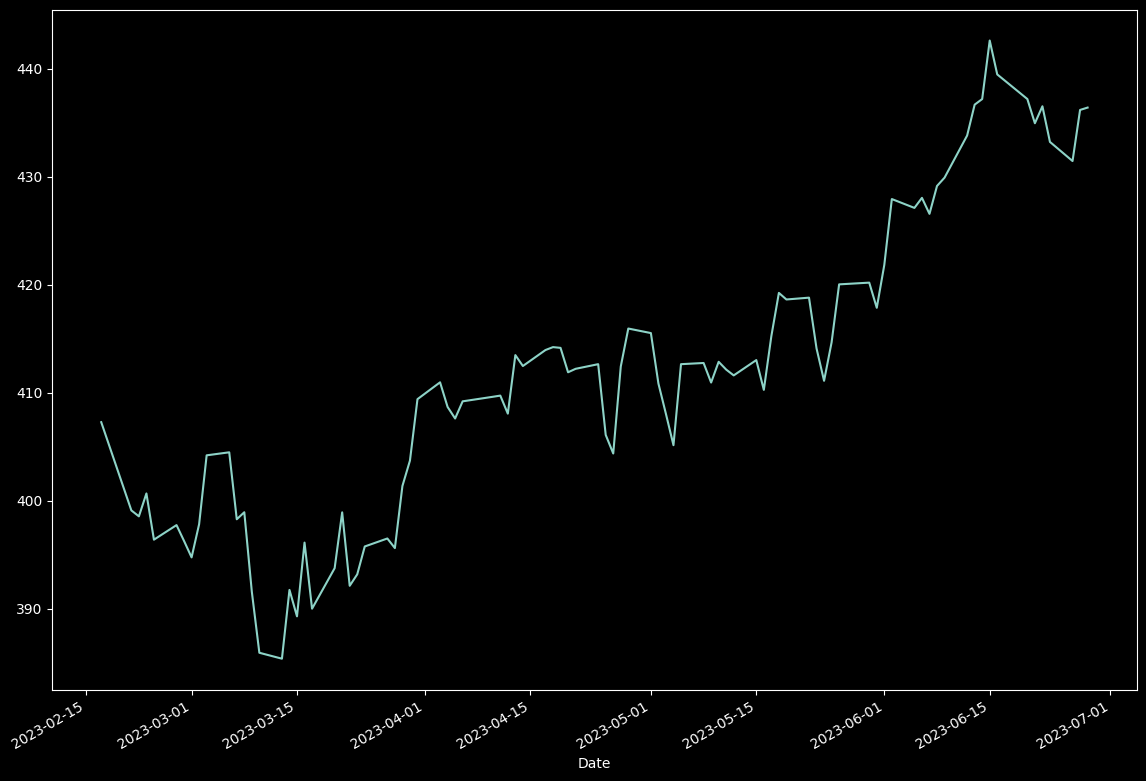

In [ ]:
### pobieranie danych historycznych przy pomocy yfinance

start = (datetime.date.today() - datetime.timedelta(dni))
koniec = datetime.datetime.today()

dane = yf.download(symbol, start=start, end=koniec, interval=czest)

### Biblioteka finta korzysta tylko z malych liter, nazwy musza zostac przerobione
dane.rename(columns={"Close": 'close', "High": 'high', "Low": 'low', 'Volume': 'volume', 'Open': 'open'}, inplace=True)
dane_tymczasowe = dane.iloc[-90:]


plt.figure(figsize=(14, 10))
plt.style.use('dark_background')

dane_tymczasowe['close'].plot()

In [ ]:
dane.head()

,open,high,low,close,Adj Close,volume
Date,,,,,,
1996-02-07,64.750000,65.140625,64.687500,65.140625,39.953838,585100
1996-02-08,65.046875,65.906250,64.921875,65.843750,40.385105,1526600
1996-02-09,65.812500,66.375000,65.515625,65.828125,40.375511,804600
1996-02-12,65.953125,66.625000,65.890625,66.328125,40.682159,626500
1996-02-13,66.046875,66.687500,66.000000,66.187500,40.595928,1045900


<Axes: title={'center': 'Kursy akcji na przestrzeni czasu - Wygladzone'}, xlabel='Date'>

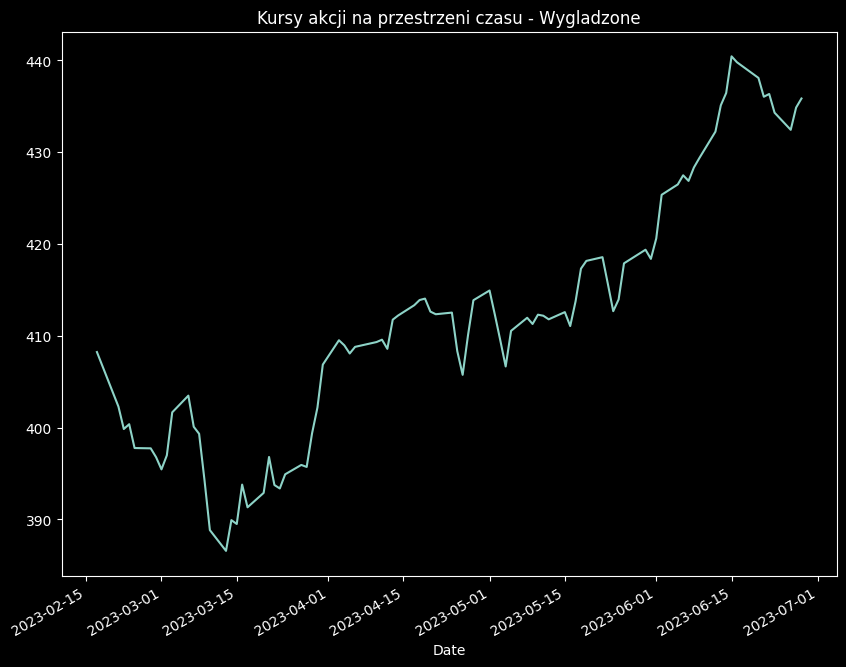

In [ ]:
### Czyszczenie i modelowanie danych


### wykladnicze wygladzenie zbioru danych,
### parametr alpha odpowiada za zwiekszenie "wagi" mlodszych parametrow
def wykladnicze_wygladzanie(dane, alpha):


    return dane.ewm(alpha=alpha).mean()

dane = wykladnicze_wygladzanie(dane, 0.65)
dane_tymczasowe2 = dane.iloc[-90:]

plt.figure(figsize=(10, 8))
plt.style.use('dark_background')
plt.title('Kursy akcji na przestrzeni czasu - Wygladzone')
dane_tymczasowe2['close'].plot()

In [ ]:
### budowa funkcji korzystajacej z biblioteki finta w celu wyliczenia indykatorow jako cech

def wylicz_indykator(dane):

    for indicator in indykatory:
        ind_data = eval('TA.' + indicator + '(dane)')
        if not isinstance(ind_data, pd.DataFrame):
            ind_data = ind_data.to_frame()
        dane = dane.merge(ind_data, left_index=True, right_index=True)
    dane.rename(columns={"14 period EMV.": '14 period EMV'}, inplace=True)

    # wyliczanie srednich ruchomych
    dane['ema50'] = dane['close'] / dane['close'].ewm(50).mean()

    dane['ema21'] = dane['close'] / dane['close'].ewm(21).mean()

    dane['ema15'] = dane['close'] / dane['close'].ewm(14).mean()

    dane['ema5'] = dane['close'] / dane['close'].ewm(5).mean()

    # normalizacja wolumenu zamiast uzycia zmieniajace sie wartosci rzeczywistej
    dane['normVol'] = dane['volume'] / dane['volume'].ewm(5).mean()

    # usuwanie niepotrzebnych danych
    del (dane['open'])
    del (dane['high'])
    del (dane['low'])
    del (dane['volume'])
    del (dane['Adj Close'])

    return dane

dane = wylicz_indykator(dane)
print(dane.columns)

Index(['close', '14 period RSI', 'DI+', 'DI-', '14 period STOCH %K', 'MFV',
       '14 period ATR', 'MOM', 'ROC', 'OBV', '20 period CCI', '14 period EMV',
       'VIm', 'VIp', 'ema50', 'ema21', 'ema15', 'ema5', 'normVol'],
      dtype='object')


In [ ]:
live_pred_data = dane.iloc[-16:-11]

In [ ]:
def okresl_predykcje(dane, przeskok):

    ###sprawdzenie czy cena zmalała 0 czy wzrosła 1, parametr przeskoku to liczba dni lub wierszy które funkcja ma ''przeskoczyc''



    predykcja = (dane.shift(-przeskok)['close'] >= dane['close'])
    predykcja = predykcja.iloc[:-przeskok]
    dane['pred'] = predykcja.astype(int)

    return dane

dane = okresl_predykcje(dane, przeskok=15)
del (dane['close'])
dane = dane.dropna() # Naprawa bledu  danych tworzonego okzajonalnie przez indykatory
dane.tail()
print(len(dane))

6862


RandomForest Accuracy = 0.6148121034651052
KNeighbors Accuracy = 0.6242069302098577
calosc Accuracy = 0.6351878965348952


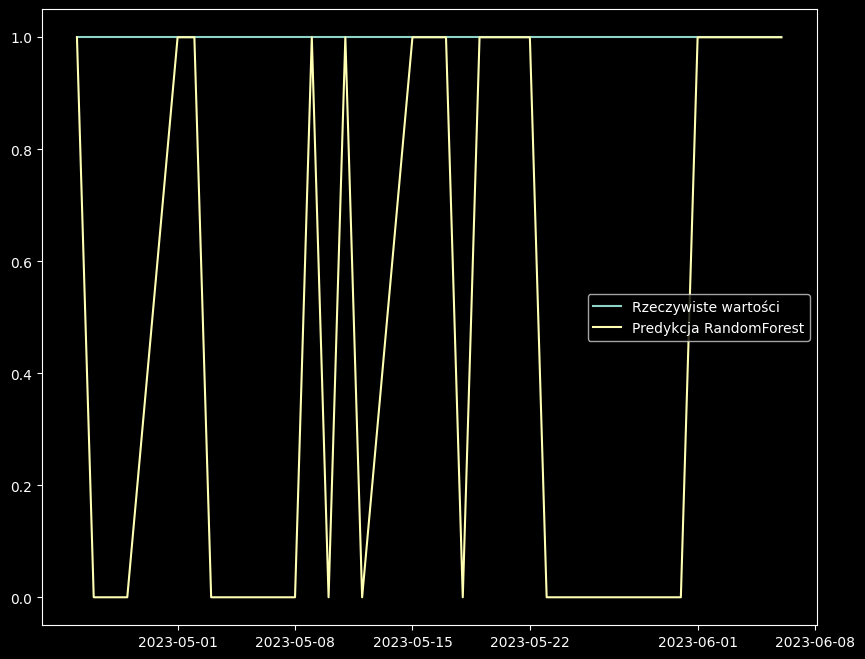

In [ ]:
def walidacja(dane):

    # podzielenie danych na partycje len train

    num_train = 10 # ilosc punktow startowych
    len_train = 40 # dlugosc zestawu do uczenia modelu

    # Utworzenie list przechowujacych wyniki modeli
    RandomForest_RESULTS = []
    KNeighbors_RESULTS = []
    calosc_RESULTS = []



    # Uzyte w badaniu modele
    RandomForest = RandomForestClassifier()
    KNeighbors = KNeighborsClassifier()

    # Lista krotek utworzona dla modeli
    estimators=[('KNeighbors', KNeighbors), ('RandomForest', RandomForest)]
    calosc = VotingClassifier(estimators, voting='soft')

    i = 0
    while True:

        # przepartycjowanie danych na fragmenty o wielkosci len_train co kazde num_train days
        dane_part = dane.iloc[i * num_train : (i * num_train) + len_train]
        # kolejne iteracje
        i += 1


        if len(dane_part) < 40:
            break

        y = dane_part['pred']
        features = [x for x in dane_part.columns if x not in ['pred']]
        X = dane_part[features]

        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 7 * len(X) // 10,shuffle=False)

        # Trenowanie modeli
        RandomForest.fit(X_train, y_train)
        KNeighbors.fit(X_train, y_train)
        calosc.fit(X_train, y_train)

        # zbieranie predykcji
        RandomForest_prediction = RandomForest.predict(X_test)
        KNeighbors_prediction = KNeighbors.predict(X_test)
        calosc_prediction = calosc.predict(X_test)

        # Weryfikacja precyzji algorytmu
        RandomForest_accuracy = accuracy_score(y_test.values, RandomForest_prediction)
        KNeighbors_accuracy = accuracy_score(y_test.values, KNeighbors_prediction)
        calosc_accuracy = accuracy_score(y_test.values, calosc_prediction)
        # Wypełnianie tabel predykcjami
        RandomForest_RESULTS.append(RandomForest_accuracy)
        KNeighbors_RESULTS.append(KNeighbors_accuracy)
        calosc_RESULTS.append(calosc_accuracy)


    RFP = pd.DataFrame(RandomForest_RESULTS)
    KNP = pd.DataFrame(KNeighbors_RESULTS)
    print('RandomForest Accuracy = ' + str( sum(RandomForest_RESULTS) / len(RandomForest_RESULTS)))
    print('KNeighbors Accuracy = ' + str( sum(KNeighbors_RESULTS) / len(KNeighbors_RESULTS)))
    print('calosc Accuracy = ' + str( sum(calosc_RESULTS) / len(calosc_RESULTS)))
    plt.figure(figsize=(10, 8))
    plt.style.use('dark_background')
    plt.plot(dane.index[-30:], dane['pred'].values[-30:], label='Rzeczywiste wartości')
    plt.plot(dane.index[-30:], np.round(RFP.values.flatten()[-30:]), label='Predykcja RandomForest')
    plt.legend()
    plt.show()
walidacja(dane)

In [ ]:
!pip install finta